In [1]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from astropy import constants as const
from astropy import units as u
from scipy.interpolate import splrep,splev
from scipy import interpolate 
from scipy import signal
import scipy.integrate as it
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
import matplotlib as mpl
from scipy.optimize import curve_fit


plt.style.use('/home/imalsky/isaac-style.txt')

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma], maxfev=5000)
    return popt

def cc(file1, file2, max_v=10):
    # Load in the Different Spectra
    wavelength1, flux1 = np.loadtxt(file1, unpack=True)
    wavelength2, flux2 = np.loadtxt(file2, unpack=True)
    
    # Get the correlation
    corr_raw = signal.correlate(flux1, flux2, mode='same')
    corr = [float(i)/sum(corr_raw) for i in corr_raw]
    
    # Do the Doppler Shift off of the central value
    shift = [(((wavelength1[len(wavelength1) // 2] - val) * c) / val) for val in wavelength1]
        
    # Interp the function
    f = interp1d(shift, corr, kind='cubic')
    x = np.linspace(-max_v, max_v, num=500)
    y = f(x)

    return x, y

def interp_x_y(x_input, y_input, max_v):
    f8 = interp1d(x_input, y_input / max(y_input), kind='cubic')
    x_new = np.linspace(-max_v, max_v, num=2500)
    y_new = f8(x_new)
    return x_new, y_new

[5.530714224545012, 5.602779739050254, 5.175473873027029, 4.559564484843575, 4.441952997905225, 3.8825543741284867, 4.118622937142842, 4.851830761020698]
4.7704366739578905
[5.404024262459437, 5.411016065354795, 5.132092569072354, 4.54246191263605, 4.4245822246959055, 3.7861815647641457, 4.131710795714493, 4.68804083704503]
4.690013778967776
[4.901600568837136, 4.700625399141525, 4.527785752138246, 4.204999946815573, 4.0233140671228345, 3.456500733416034, 4.236829087315137, 4.262271011443974]
4.289240820778808
[3.640723498518401, 3.615805288004724, 3.4646770487115597, 3.3437915981454363, 3.2581845320523795, 3.152064015608557, 3.4863410970894515, 3.412503452280151]
3.4217613163013327
[2.877476839056127, 2.877300468569878, 2.8789902322634577, 2.8779399747074614, 2.877501838804335, 2.8772453440868024, 2.8791310328832984, 2.877887784393065]
2.8779341893455532


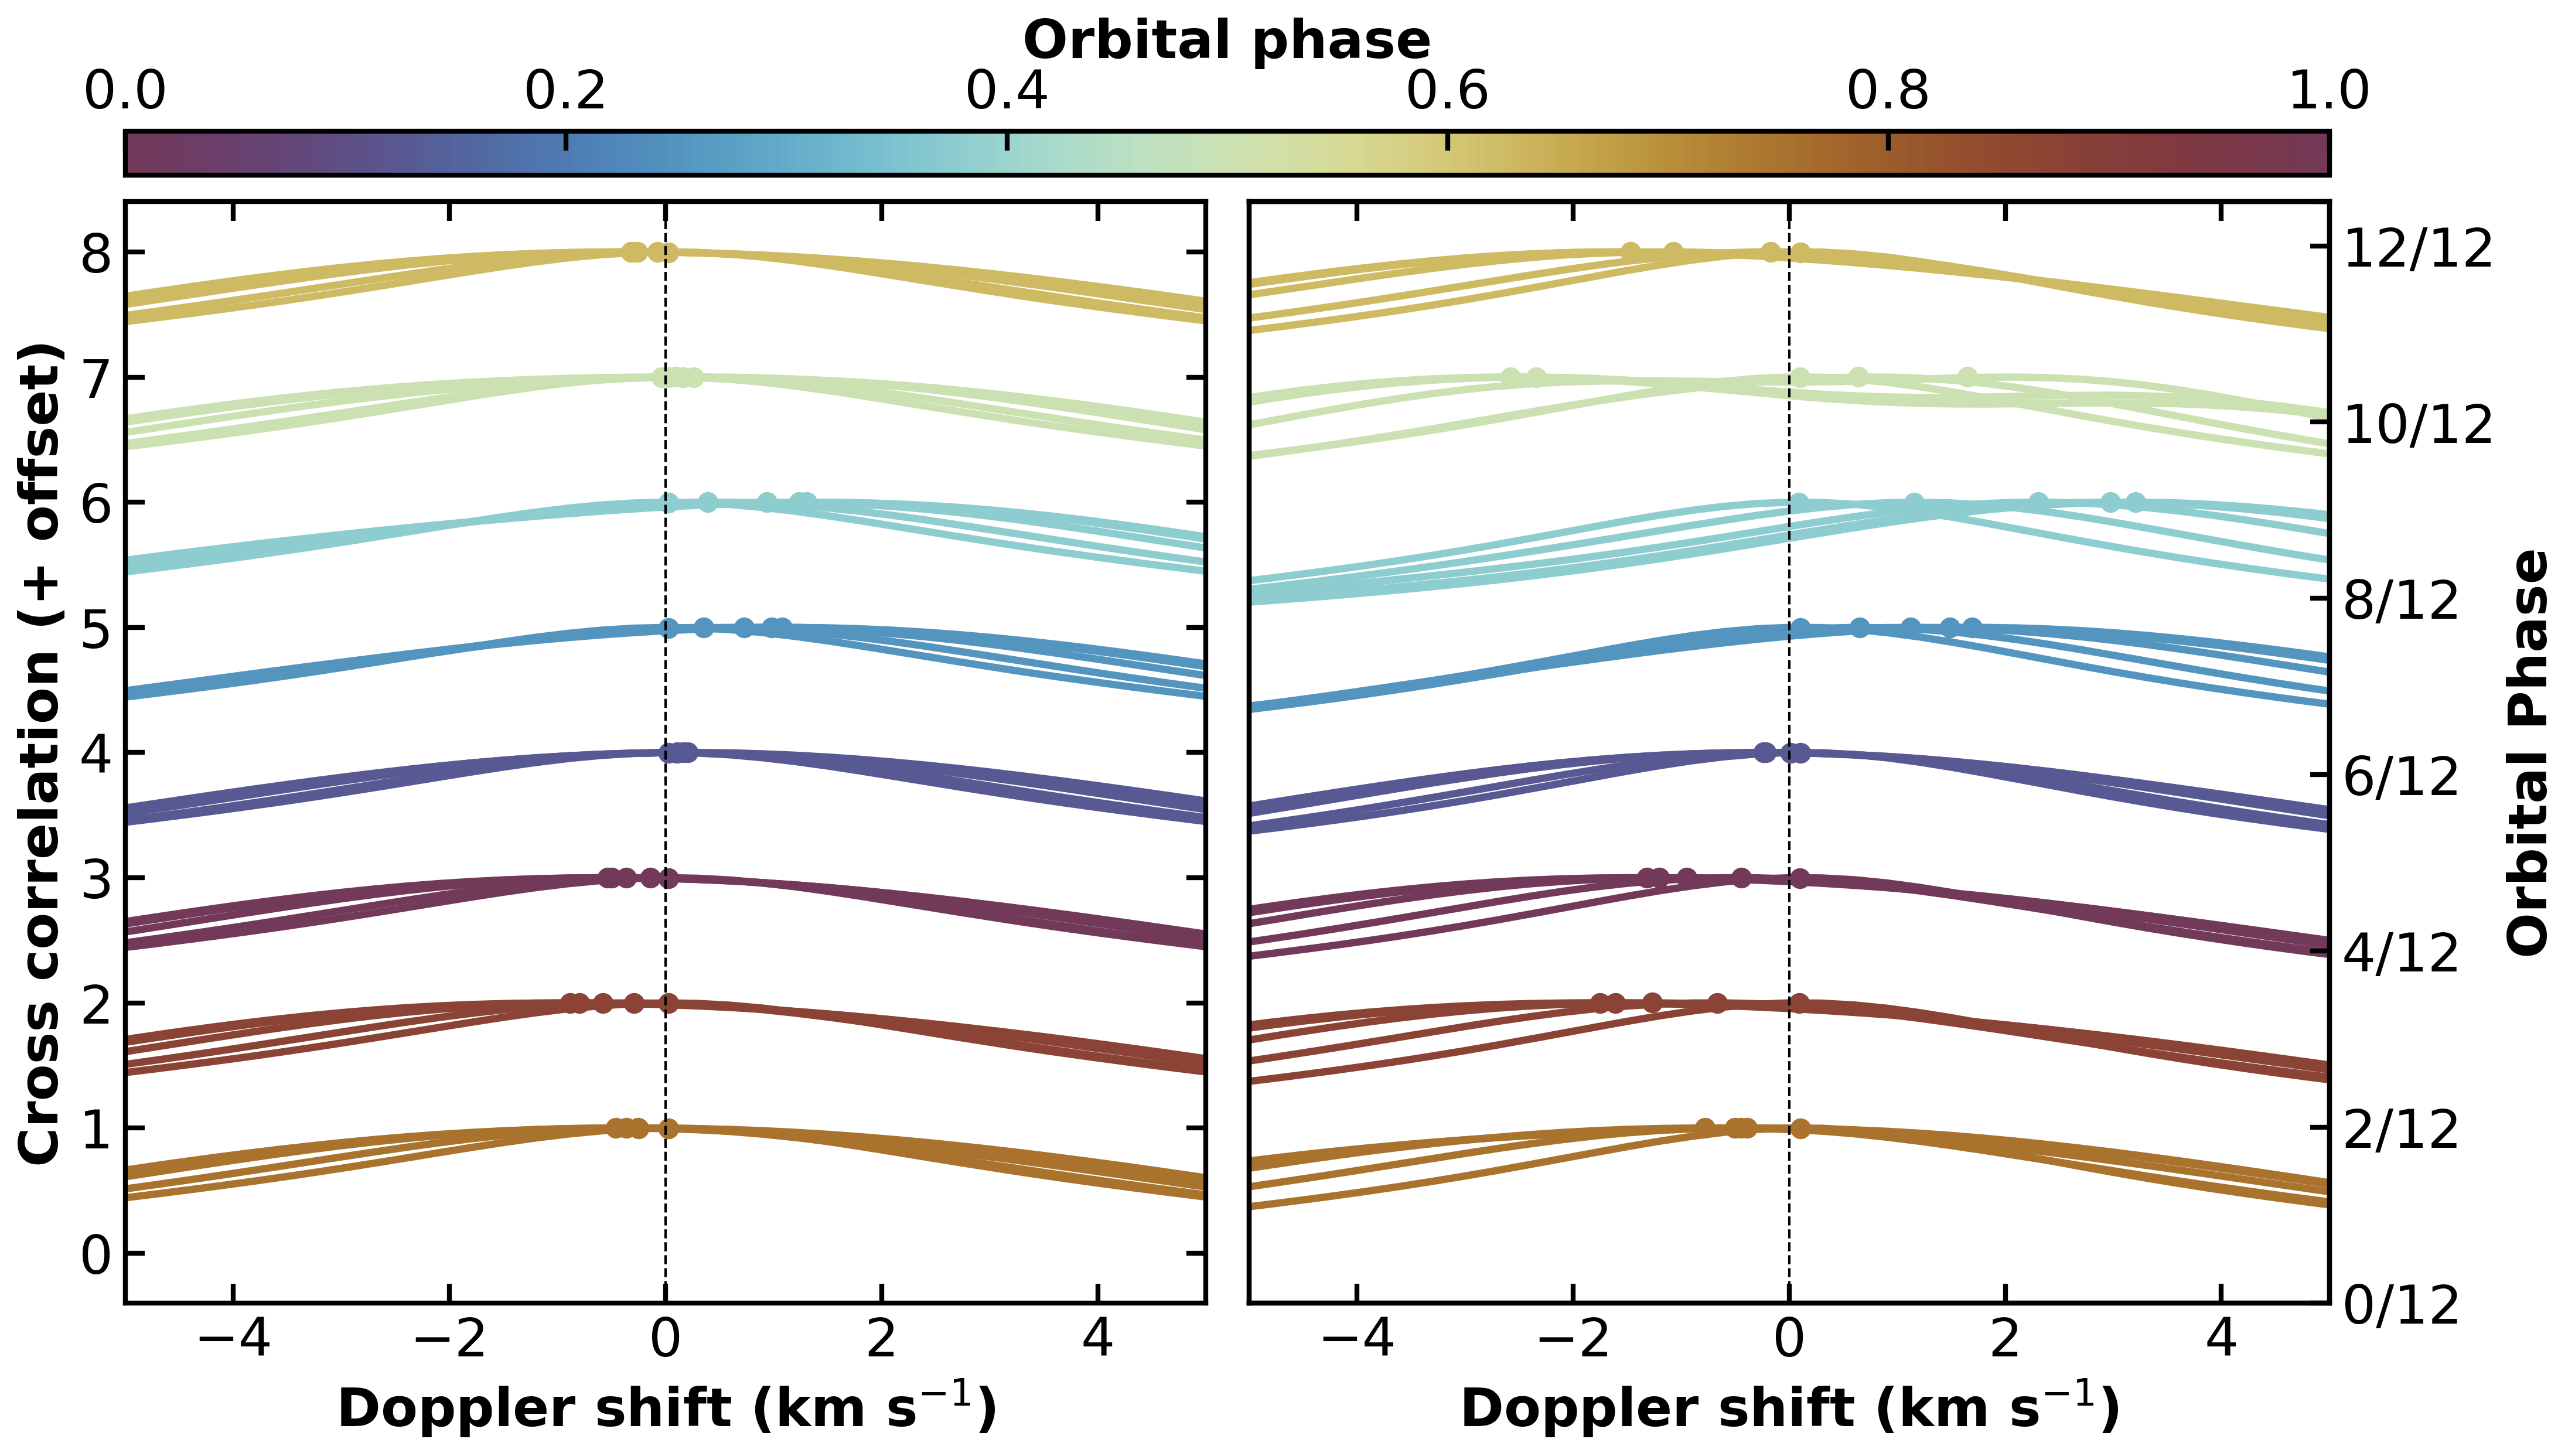

In [3]:
# Figure aesthetics
fig, axes = plt.subplots(1, 2, figsize=(16.18, 10))
plt.subplots_adjust(wspace=0.04, hspace=0)

font = {'size' : 16, 'family' : 'sans-serif'}
plt.rc('font', **font)


base = '/home/imalsky/Desktop/spectra/'

#inclinations1 = ['1.152']
#inclinations2 = ['1.152']


inclinations1 = ['0.0', '0.39269908', '0.78539816','1.17809725','1.57079633']
inclinations2 = ['0.0', '0.393', '0.785', '1.178', '1.5708']

#phases = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]
phases = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]


#buda, batlow, roma, 
cm_name = 'romaO'
cm_file = np.loadtxt(f'ScientificColourMaps6/{cm_name}/{cm_name}.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])
colors = np.linspace(0, 256, len(phases) + 1)

# define Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) * (x - x0) / (2 * sigma * sigma))


for j in range(len(inclinations1)):
    i = 0
    clear_list  = []
    cloudy_list = []
    
    sigmas = []
    for phase in phases:
        inc1   = str(inclinations1[j])
        inc2   = str(inclinations2[j])

        phase = str(phase)

        color_val = int(colors[i]) - 64
        if color_val < 0:
            color_val = color_val + 256  

        # Do the clear one!
        file1 = base + 'Spec_0_{}_phase_{}_inc_{}000.00.dat'.format('UPS-LOW-G-CLEAR-250', phase, inc1)
        file2 = base + 'Spec_1_{}_phase_{}_inc_{}000.00.dat'.format('UPS-LOW-G-CLEAR-250', phase, inc1)

        tw, tf = np.loadtxt(file1, unpack=True)
        dw, df = np.loadtxt(file2, unpack=True)

        # Get the cross correlation
        rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, skipedge=200)

        # normalize cc function 
        cc = (cc - min(cc)) / (max(cc) - min(cc))

        # Find the index of maximum cross-correlation function
        maxind = np.argmax(cc)

        # fit Guassian to peak region of cc function
        rv_range = rv[maxind - 20: maxind + 20]
        cc_range = cc[maxind - 20: maxind + 20]

        popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

        # calculate best fit guassian
        rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
        cc_fit = gaussian(rv_fit, *popt)

        # index of maximum of Gaussian
        max_gauss = np.argmax(cc_fit) 

        # plot CCFs
        axes[0].plot(rv, cc + i, lw=3, color=my_colors(color_val))
        axes[0].plot(rv_fit[max_gauss], cc_fit[max_gauss] + i, '.', ms=15, color=my_colors(color_val))    
        clear_list.append(rv_fit[max_gauss])
        
        #val1, val2, sigma = popt
        #sigmas.append(sigma)        
        
        
        
        

        # Do the cloudy one!
        file1 = base + 'Spec_0_{}_phase_{}_inc_{}000.00.dat'.format('UPS-LOW-G-CLOUDY-250', phase, inc2)
        file2 = base + 'Spec_1_{}_phase_{}_inc_{}000.00.dat'.format('UPS-LOW-G-CLOUDY-250', phase, inc2)
        tw, tf = np.loadtxt(file1, unpack=True)
        dw, df = np.loadtxt(file2, unpack=True)

        # Get the cross correlation
        rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -10., 10., 0.1, skipedge=200)

        # normalize cc function 
        cc = (cc - min(cc)) / (max(cc) - min(cc))

        # Find the index of maximum cross-correlation function
        maxind = np.argmax(cc)

        # fit Guassian to peak region of cc function
        rv_range = rv[maxind - 20: maxind + 20]
        cc_range = cc[maxind - 20: maxind + 20]

        popt, pcov = curve_fit(gaussian, rv_range, cc_range, p0=[1, 0, 1])

        # calculate best fit guassian
        rv_fit = np.linspace(rv[maxind - 20], rv[maxind + 20], 1000)
        cc_fit = gaussian(rv_fit, *popt)

        # index of maximum of Gaussian
        max_gauss = np.argmax(cc_fit) 

        # plot CCFs
        axes[1].plot(rv, cc + i, lw=3, color=my_colors(color_val))
        axes[1].plot(rv_fit[max_gauss], cc_fit[max_gauss] + i, '.', ms=15, color=my_colors(color_val))        
        cloudy_list.append(rv_fit[max_gauss])
        
        val1, val2, sigma = popt
        sigmas.append(sigma)
        
        i = i+1

    clear_rounded = [ round(elem, 4) for elem in clear_list ]
    cloudy_rounded = [ round(elem, 4) for elem in cloudy_list ]
    print (sigmas)
    print (np.mean(sigmas))

    #print (clear_rounded)
    #print (cloudy_rounded)
    
cloudy_ax = axes[1].twinx()
x_ticks_labels = ['0/12', '2/12', '4/12', '6/12', '8/12', '10/12', '12/12']

axes[1].yaxis.set_ticks([])
cloudy_ax.set_yticks([0, 2, 4, 6, 8, 10, 12, 12.5])
cloudy_ax.set_yticklabels(x_ticks_labels)

#axes[0].xaxis.set_ticks([-5, -4, -2, 0, 2, 4, 6])
#axes[1].xaxis.set_ticks([-6, -4, -2, 0, 2, 4, 6])

axes[0].set_xlim(-5, 5)
axes[1].set_xlim(-5, 5)

axes[0].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
axes[1].set_xlabel('Doppler shift (km s$^{-1}$)',fontsize=22, weight='bold')
axes[0].set_ylabel('Cross correlation (+ offset)',fontsize=22, weight='bold')

cloudy_ax.set_ylabel('Orbital Phase',fontsize=22, weight='bold')

axes[0].axvline(linewidth=1, color='k',linestyle='dashed')
axes[1].axvline(linewidth=1, color='k',linestyle='dashed')
    
sm = plt.cm.ScalarMappable(cmap=my_colors, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='top', aspect=50, pad=0.02)
cbar.set_label('Orbital phase', fontsize=22, weight='bold')
#plt.savefig('/home/imalsky/Desktop/ccs.png', bbox_inches='tight', dpi=200)

In [6]:
ups_clear = [-0.27, -0.318, -0.274, -0.1539, 0.014, 0.2099, 0.3821, 0.4579, 0.3581, 0.1739, -0.01, -0.1579]
ups_cloudy = [-0.5379, -0.7061, -0.6701, -0.4779, -0.1899, 0.2059, 0.6821, 1.1339, 1.242, 0.6898, -0.046, -0.326]

clear_1 = [-0.254, -0.882, -0.5379, 0.2059, 1.0819, 1.3098, -0.038, -0.314]
clear_2 = [-0.3621, -0.7939, -0.4979, 0.1659, 0.9821, 1.238, 0.0941, -0.322]
clear_3 = [-0.4579, -0.582, -0.3621, 0.1101, 0.7298, 0.938, 0.262, -0.258]
clear_4 = [-0.2499, -0.29, -0.1381, 0.1061, 0.3541, 0.3901, 0.1659, -0.0741]
clear_5 = [0.03, 0.026, 0.026, 0.03, 0.03, 0.026, 0.026, 0.03]

cloudy_1 = [-0.3901, -1.7499, -1.3178, -0.2299, 1.6939, 3.2059, -2.5819, -1.466]
cloudy_2 = [-0.4502, -1.6098, -1.202, -0.2379, 1.49, 2.974, -2.3419, -1.47]
cloudy_3 = [-0.7819, -1.2698, -0.946, -0.2139, 1.1219, 2.3059, 1.6495, -1.0699]
cloudy_4 = [-0.5019, -0.6661, -0.4418, 0.014, 0.6501, 1.158, 0.6418, -0.1739]
cloudy_5 = [0.1021, 0.0941, 0.0981, 0.1021, 0.1021, 0.0901, 0.0981, 0.1021]


print (np.mean(np.abs(clear_1)), np.mean(np.abs(clear_5)), np.mean(np.abs(cloudy_1)), np.mean(np.abs(cloudy_5)))

0.5779375 0.027999999999999997 1.579425 0.0986


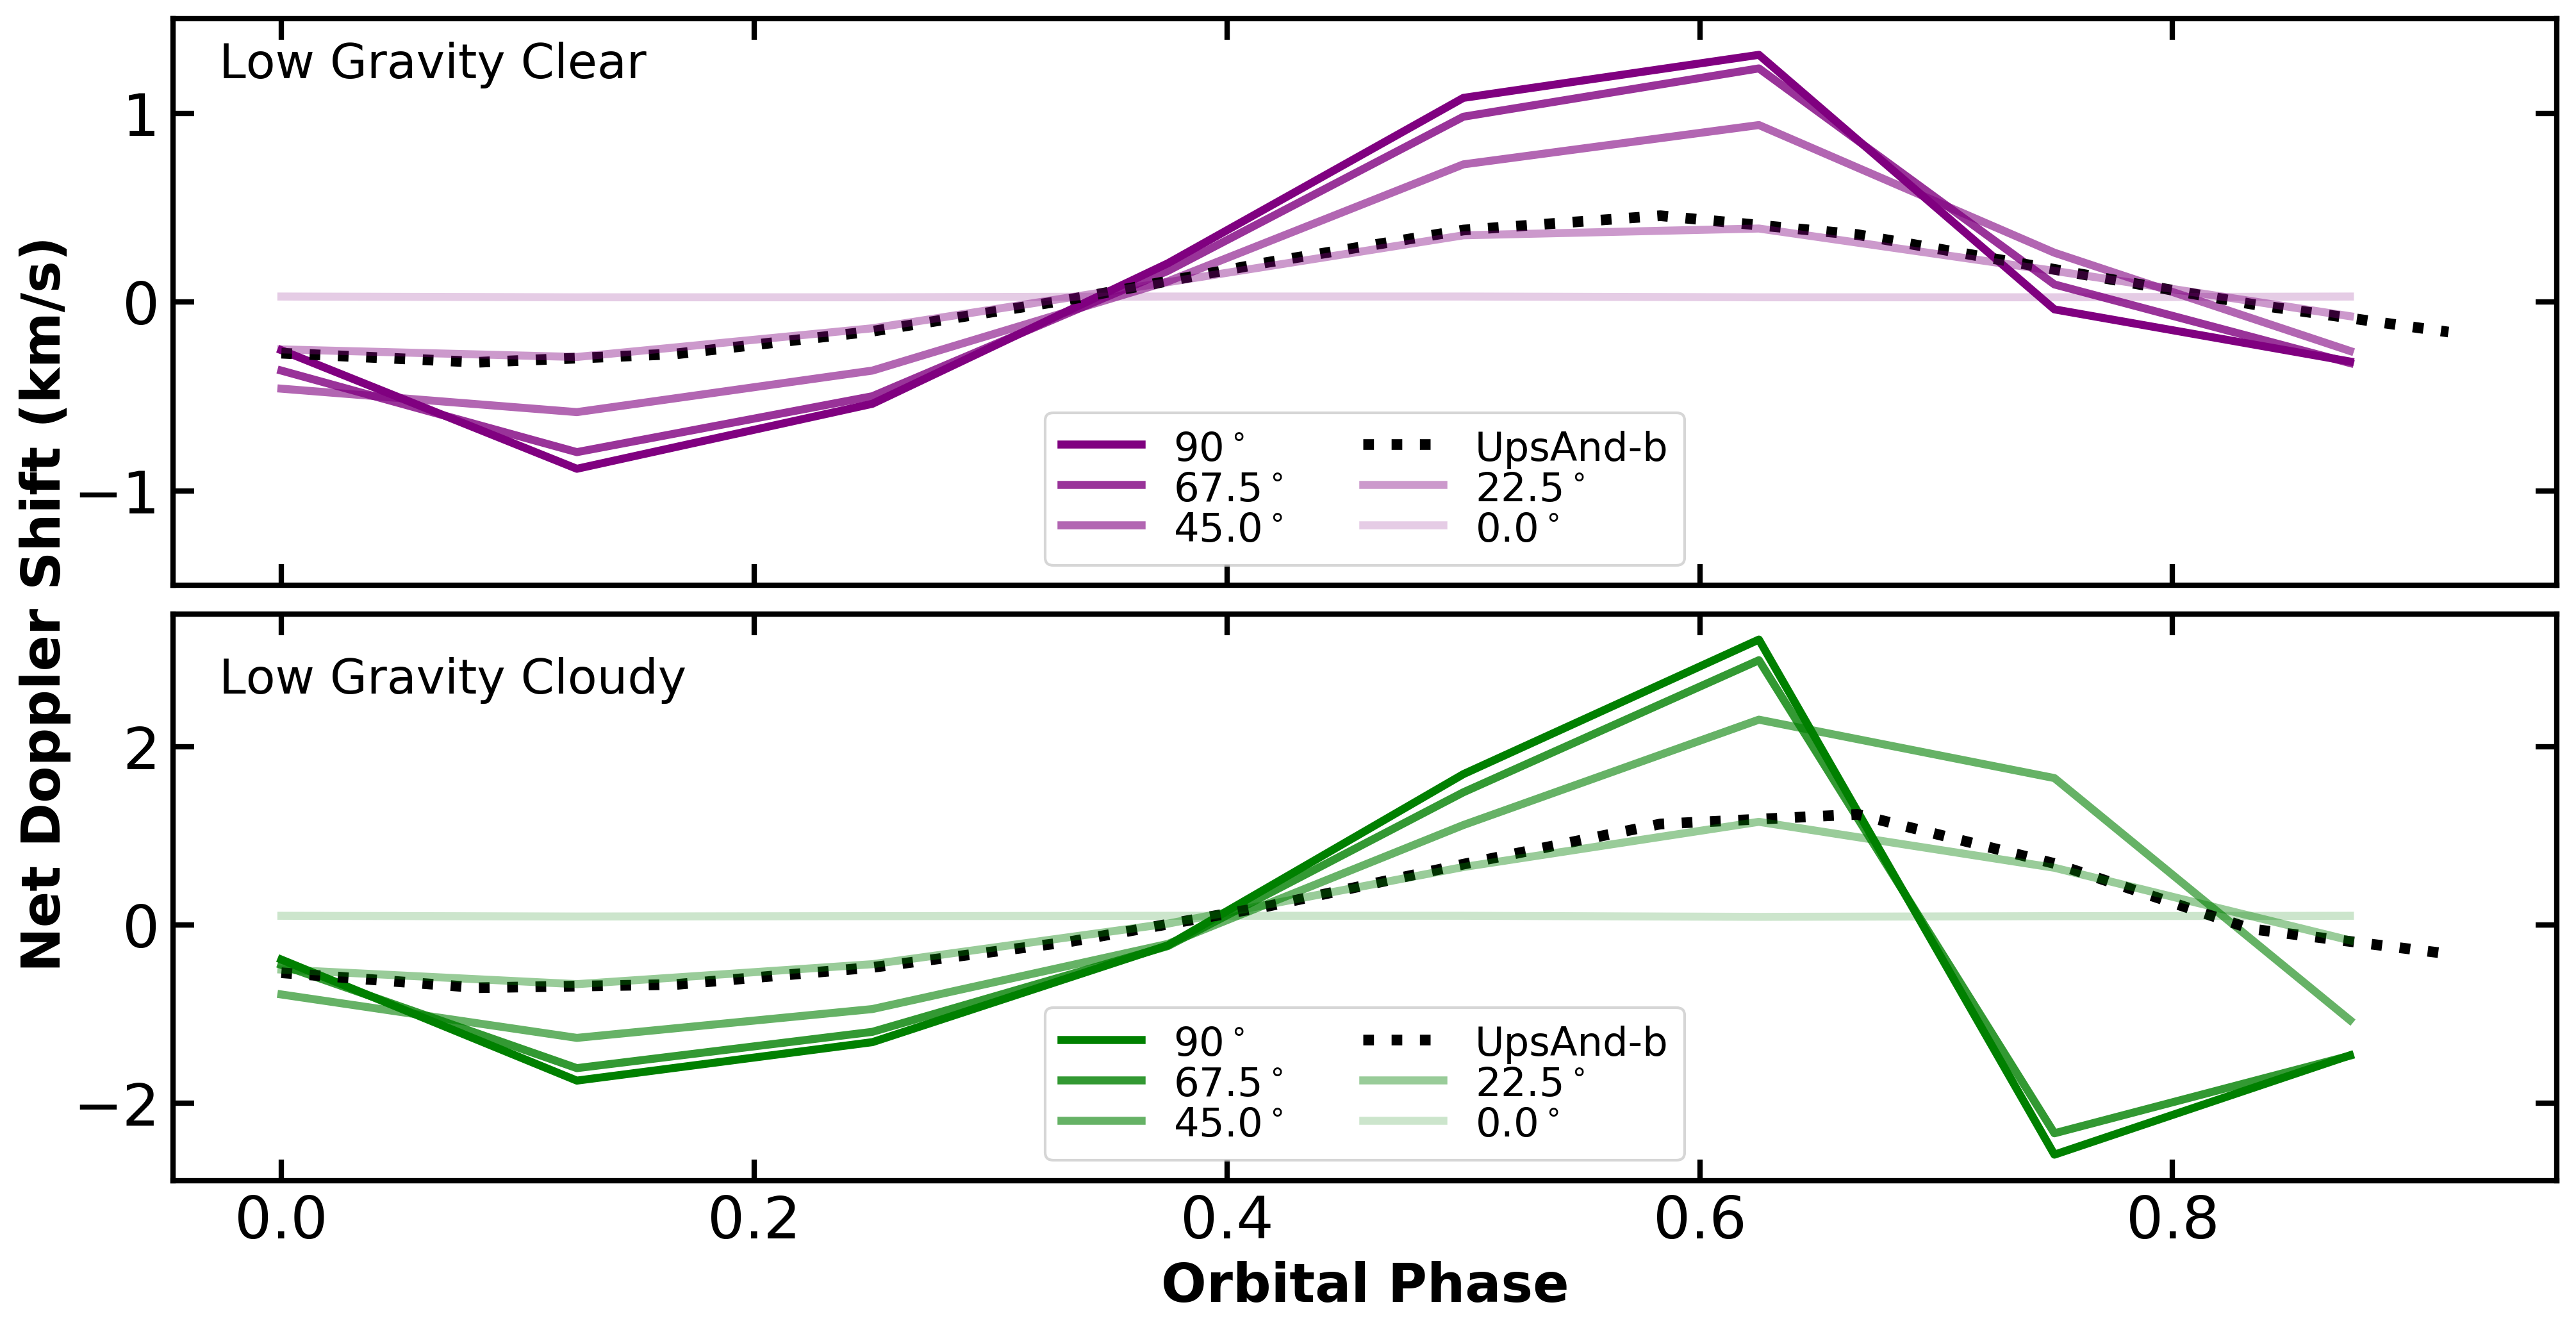

In [13]:
fig, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(16,8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
from scipy.interpolate import interp1d

phases = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0,
          180.0, 210.0, 240.0, 270.0, 300.0, 330.0]

phases2 = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

phases = np.asarray(phases) / 360
phases2 = np.asarray(phases2) / 360


ax[0].plot(phases2, clear_1, color='purple', alpha=1.0, linewidth=3, label=r'90$^\circ$')
ax[0].plot(phases2, clear_2, color='purple', alpha=0.8, linewidth=3, label=r'67.5$^\circ$')
ax[0].plot(phases2, clear_3, color='purple', alpha=0.6, linewidth=3, label=r'45.0$^\circ$')
ax[0].plot(phases, ups_clear, color='black', linestyle='dotted', linewidth=4, label=r'UpsAnd-b')
ax[0].plot(phases2, clear_4, color='purple', alpha=0.4, linewidth=3, label=r'22.5$^\circ$')
ax[0].plot(phases2, clear_5, color='purple', alpha=0.2, linewidth=3, label=r'0.0$^\circ$')

#ax[0].set_ylabel('Net Doppler Shift [km/s]', fontsize=18, weight='bold')
#ax[0].set_xlabel('Orbital Phase', fontsize=18, weight='bold')



ax[1].plot(phases2, cloudy_1, color='green', alpha=1.0, linewidth=3, label=r'90$^\circ$')
ax[1].plot(phases2, cloudy_2, color='green', alpha=0.8, linewidth=3, label=r'67.5$^\circ$')
ax[1].plot(phases2, cloudy_3, color='green', alpha=0.6, linewidth=3, label=r'45.0$^\circ$')
ax[1].plot(phases, ups_cloudy, color='black', linestyle='dotted', linewidth=4, label=r'UpsAnd-b')
ax[1].plot(phases2, cloudy_4, color='green', alpha=0.4, linewidth=3, label=r'22.5$^\circ$')
ax[1].plot(phases2, cloudy_5, color='green', alpha=0.2, linewidth=3, label=r'0.0$^\circ$')


ax[1].set_xlabel('Orbital Phase', fontsize=20, weight='bold')

ax[0].legend(fontsize=15, ncol=2, handleheight=1, labelspacing=0.01, loc='lower center')
ax[1].legend(fontsize=15, ncol=2, handleheight=1, labelspacing=0.01, loc='lower center')

#ax[0].set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
#ax[1].set_yticks([-2.0,-1.0, 0.0, 1.0, 2.0])

ax[0].set_ylim(-1.5,1.5)
#ax[1].set_ylim(-1.5,1.5)


fig.text(0.14, 0.85, r"Low Gravity Clear", size=18, weight='normal', va='center')
fig.text(0.14, 0.45, r"Low Gravity Cloudy", size=18, weight='normal', va='center')


fig.text(0.075, 0.5, r"Net Doppler Shift (km/s)", size=20, weight='bold', va='center', rotation='vertical')

plt.savefig('/home/imalsky/Desktop/net-dopplers.png', bbox_inches='tight', dpi=200)